In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15,3)
from IPython.display import display

In [2]:
import numpy as np

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

---

Use some matrix... just check if it trains and if so how quickly

In [4]:
from movieLensAnalyzer import MovieLensAnalyzer 
movieLensAnalyzer = MovieLensAnalyzer()
R_train = movieLensAnalyzer.trainRatingMatrix
R_test = movieLensAnalyzer.testRatingMatrix
R = R_train + R_test

In [5]:
np.sum(R>0)

100000

---

In [6]:
print("% of items: ", np.sum(R > 0) / (R.shape[0] * R.shape[1]))

R_dense = np.copy(R)
MIN_PERC_FILLED = 0.3

idx = []
# Remove items
for j in range(R_dense.shape[1]):
    perc_filled = np.sum(R_dense[:,j] > 0) / R_dense.shape[0]
    if perc_filled >= MIN_PERC_FILLED:
        idx.append(j)
R_dense = R_dense[:, idx]
R_dense.shape

idx = []
# Remove users
for i in range(R_dense.shape[0]):
    perc_filled = np.sum(R_dense[i,:] > 0) / R_dense.shape[1]
    if perc_filled >= MIN_PERC_FILLED:
        idx.append(i)
R_dense = R_dense[idx, :]
R_dense.shape

print("% of items: ", np.sum(R_dense > 0) / (R_dense.shape[0] * R_dense.shape[1]))

% of items:  0.0630466936422
% of items:  0.555527743012


In [7]:
R = R_dense

---

The point of this is to check that if we can fine-tune a model and still obtain meaningful uncertainty **updates** per user.

First, we pick a significant amount of users to check.

In [8]:
NUM_USERS_DENSE = 20
NUM_USERS_SPARS = 20
PERC_DROP = 0.3 # approximately.

rating_density_per_user = list(zip(np.sum(R>0, axis=1), range(R.shape[0])))
dense_users = sorted(rating_density_per_user, key=lambda x: -x[0])[:NUM_USERS_DENSE]
spars_users = sorted(rating_density_per_user, key=lambda x:  x[0])[:NUM_USERS_SPARS]

train_mask = R > 0

# The test masks we'll use later.
test_masks = {}

# We artifically dropout some elements from the users we're interested in. Assume the rest of the matrix is filled.
np.random.seed(1337)
for _, idx in (dense_users + spars_users):
    before = np.copy(train_mask[idx, :])
    
    dropout = 1-np.random.binomial(1, PERC_DROP, size=R.shape[1])
    train_mask[idx, :] = dropout * train_mask[idx, :]
    
    test_mask = np.bitwise_xor(before, train_mask[idx, :])
    test_masks[idx] = test_mask

In [9]:
# sanity check
print(np.sum(train_mask))
print(np.sum([np.sum(m) for _, m in test_masks.items()]))

12958
358


---

Our NNMF model.

We train it once a lot of iterations (2000 by default), which is pretty much convergence.

Edit: Training till 2000, each finetune is not showing any improvement in entropy. This can be either because:
- Each finetuning steps is not trained enough (I don't have enough compute power to explore this)
- Or it's stuck at a local minima; we can try training less iterations at the beginning.

TODO:
- Check how much entropy is going down over the iterations while the model is training. I wonder if it's going down at all, and where it gets stuck!

In [10]:
from nnmf import NNMF
model = NNMF(ratingMatrix=R)

In [14]:
# get user entropy
from empirical_entropy import empirical_entropy
def get_entropy_data(model, user_index, intended_mask, num_samples=500):
    samples = model.sample_for_user(user_index, num_samples)
    _, per_item_entropy = empirical_entropy(samples)
    mean_all_entropy = np.mean(per_item_entropy[np.where(R[user_index,:] > 0)]) # all items we could see
    mean_intended_entropy = np.mean(per_item_entropy[np.where(intended_mask)]) # just elements we meant to test on
    return mean_all_entropy, mean_intended_entropy

In [18]:
def plot_R(rhats, r=None, title=''):
    _, n_items = rhats.shape
    f, axes = plt.subplots(1, n_items, sharex=True, sharey=True)
    i = 0
    for j in range(n_items):
        if r is not None:
            axes[j].axvline(x=r[j], color='r', alpha=0.4)
        axes[j].hist(rhats[:,j], histtype='stepfilled', normed=True, bins=100)
    plt.xlim([0,6])
    f.suptitle(title)
    plt.show()

In [31]:
def joint_entropy(vars):
    marginal_entropy = 0.5*np.log(2*np.pi*np.e*vars)
    joint_entropy = np.sum(vars, axis=1)
    return joint_entropy

---

In [11]:
# Test loading good initial params from NNMFVanilla
import edward as ed
import _pickle
import tensorflow as tf

nnmf_vanilla_filename = 'nnmf_vanilla_6000.pkl'

sess = model.sess
trained_vars = _pickle.load(open(nnmf_vanilla_filename, "rb"))

display([x.shape for x in trained_vars])

graph_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
display(graph_vars)
sess.run(graph_vars[0].assign(trained_vars[0]))
sess.run(graph_vars[2].assign(trained_vars[1]))
sess.run(graph_vars[4].assign(trained_vars[2]))
sess.run(graph_vars[6].assign(trained_vars[3]))

nn_vars = [x for x in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if x.name.startswith('nn/')]
display(nn_vars)
sess.run(nn_vars[0].assign(trained_vars[4]))
sess.run(nn_vars[1].assign(trained_vars[5]))
sess.run(nn_vars[2].assign(trained_vars[6]))
sess.run(nn_vars[3].assign(trained_vars[7]))

print("Loaded vars from NNMFVanilla")

[(510, 10), (47, 10), (510, 10), (47, 10), (30, 20), (1, 20), (20, 1), (1, 1)]

[<tf.Variable 'Variable:0' shape=(510, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(510, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(47, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(47, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(510, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(510, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(47, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(47, 10) dtype=float32_ref>]

[<tf.Variable 'nn/W1:0' shape=(30, 20) dtype=float32_ref>,
 <tf.Variable 'nn/b1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'nn/W2:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'nn/b2:0' shape=(1, 1) dtype=float32_ref>]

Loaded vars from NNMFVanilla


## EXP BEGIN

In [13]:
model.save('start.ckpt')

'start.ckpt'

In [15]:
model.load('start.ckpt')

INFO:tensorflow:Restoring parameters from start.ckpt


In [16]:
entropy_data = []
user = spars_users[0][1] #dense_users[0][1]

In [17]:
import tensorflow as tf

In [18]:
def get_latents_entropy(model):
    with model.sess.as_default() as sess:
        #display(tf.trainable_variables())
        #qU_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0])
        qU_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[1]))
        #qV_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[2])
        qV_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[3]))
        #qUp_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[4])
        qUp_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[5]))
        #qVp_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[6])
        qVp_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[7]))
        
        qU_entropy = joint_entropy(qU_v)
        qV_entropy = joint_entropy(qV_v)
        qUp_entropy = joint_entropy(qUp_v)
        qVp_entropy = joint_entropy(qVp_v)
        return qU_entropy, qV_entropy, qUp_entropy, qVp_entropy

In [19]:
def debug(iteration, user):
    print("Iteration {}".format(iteration))
    samples = model.sample_for_user(user, 1000)
    test_samples = samples[:,np.squeeze(np.where(test_masks[user]))]
    trin_samples = samples[:,np.squeeze(np.where(train_mask[user,:]))]
    plot_R(test_samples[:,:4], title='Test Samples')
    plot_R(trin_samples[:,:4], title='Trin Samples')

    if iteration > -100:
        entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
        plt.plot([x[0] for x in entropy_data], label='mean all')
        plt.plot([x[1] for x in entropy_data], label='mean test')
        plt.legend()
        plt.title('entropy so far')
        _ = plt.show()

        qU_entropy, qV_entropy, qUp_entropy, qVp_entropy = get_latents_entropy(model)
        
        _ = plt.hist(qU_entropy, bins=100, histtype='stepfilled')
        plt.title('qU_entropy')
        plt.show()

        _ = plt.hist(qV_entropy, bins=100, histtype='stepfilled')
        plt.title('qV_entropy')
        plt.show()

        _ = plt.hist(qUp_entropy, bins=100, histtype='stepfilled')
        plt.title('qUp_entropy')
        plt.show()

        _ = plt.hist(qVp_entropy, bins=100, histtype='stepfilled')
        plt.title('qVp_entropy')
        plt.show()

Iteration -1


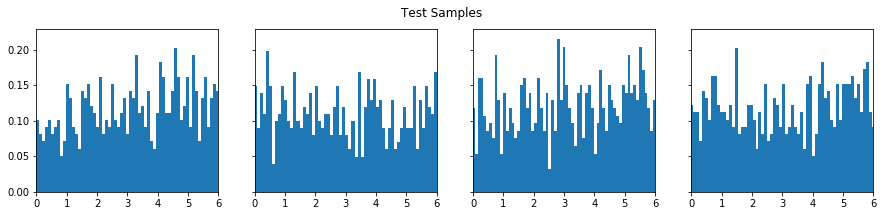

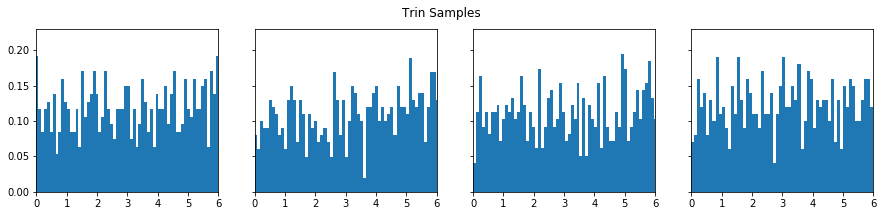

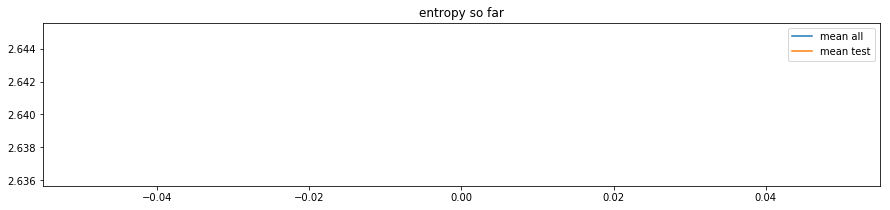

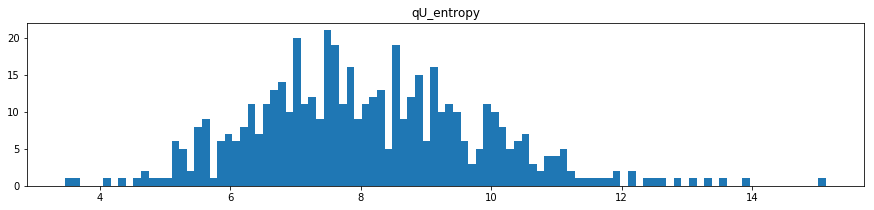

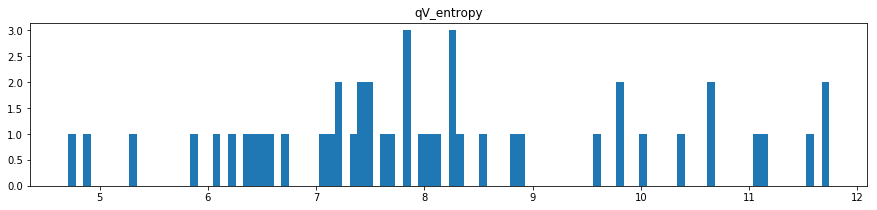

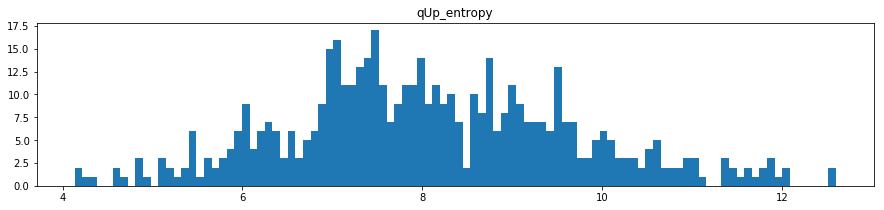

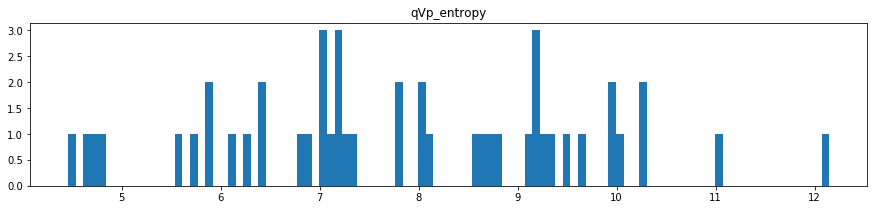

CPU times: user 52.6 s, sys: 20.1 s, total: 1min 12s
Wall time: 32.2 s
Iteration 0


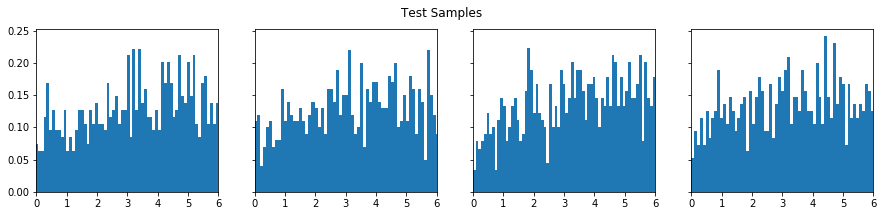

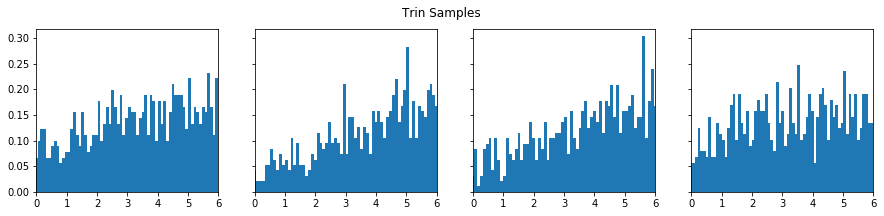

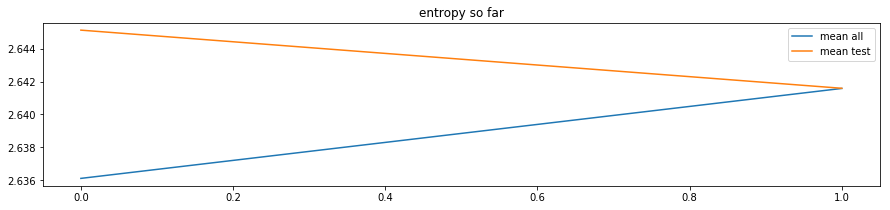

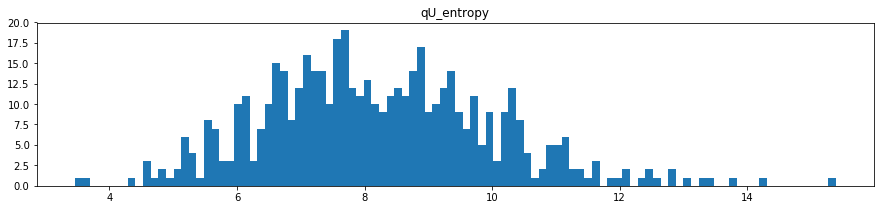

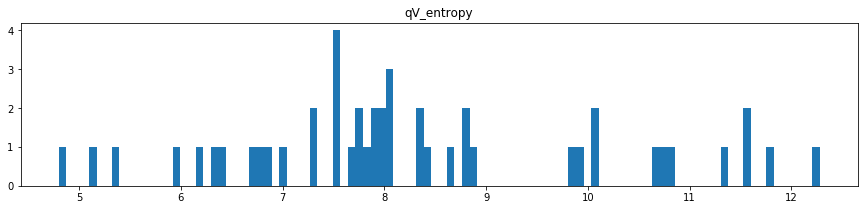

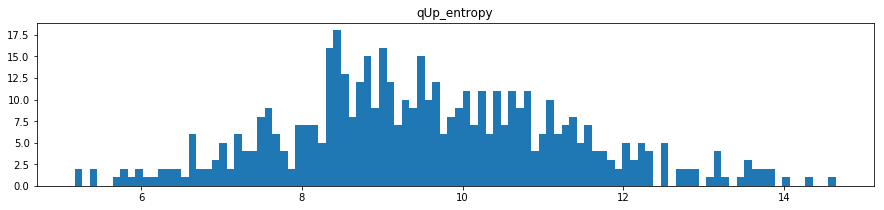

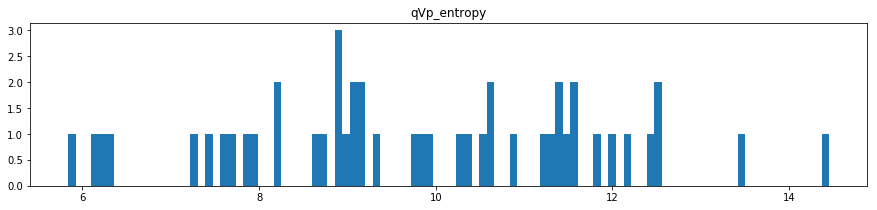

CPU times: user 51.4 s, sys: 19.3 s, total: 1min 10s
Wall time: 30.8 s
Iteration 1


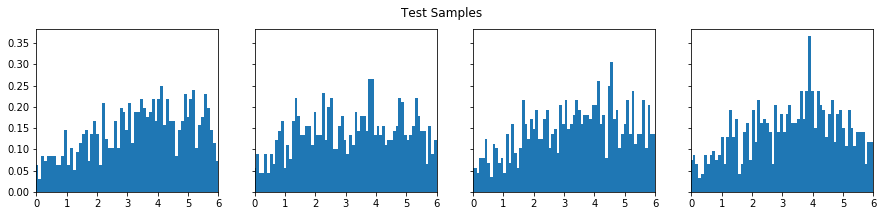

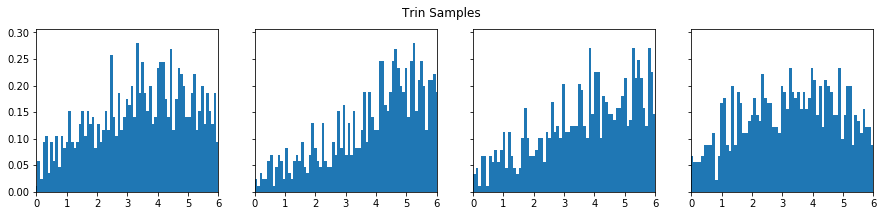

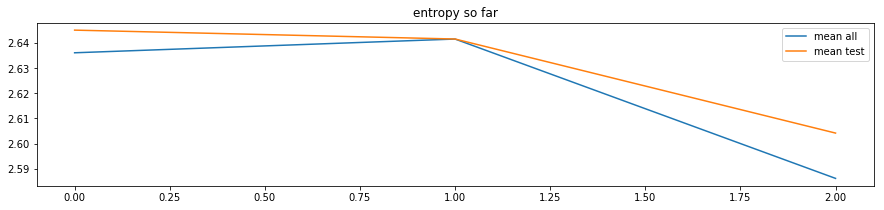

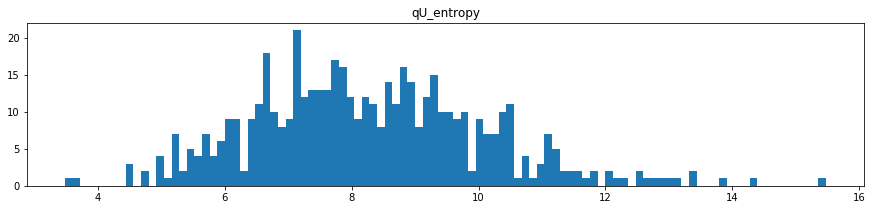

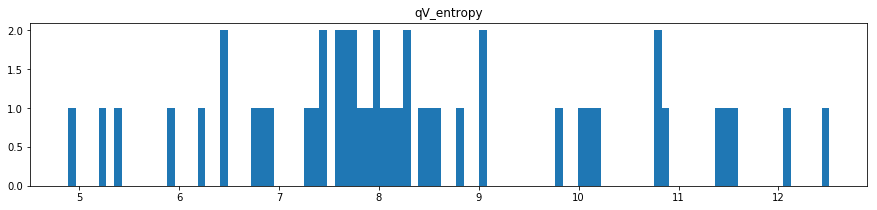

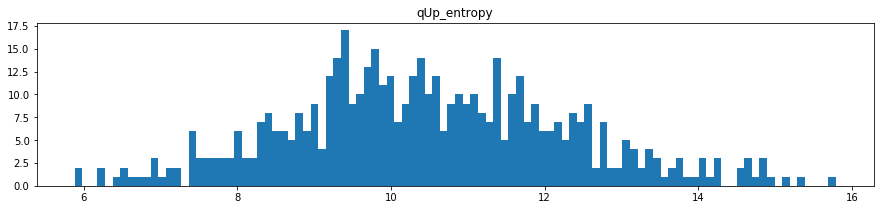

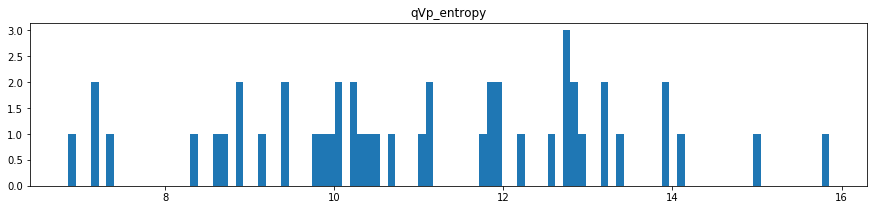

CPU times: user 51.9 s, sys: 19.2 s, total: 1min 11s
Wall time: 30.5 s
Iteration 2


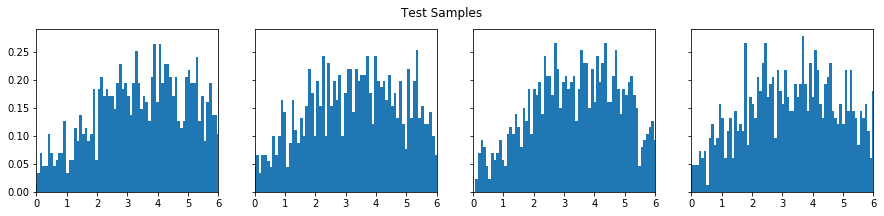

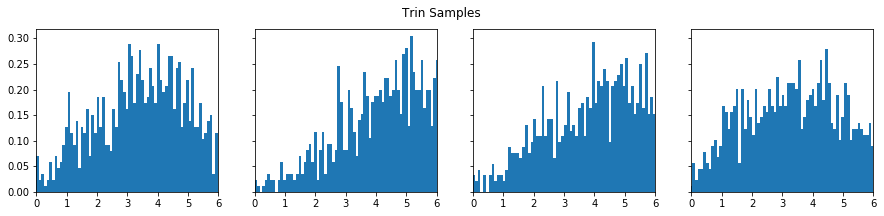

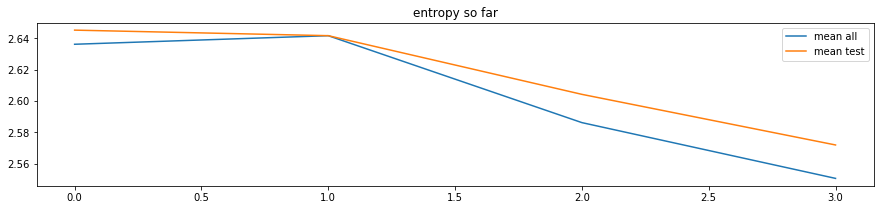

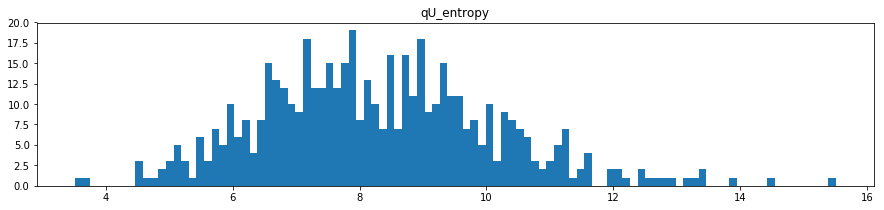

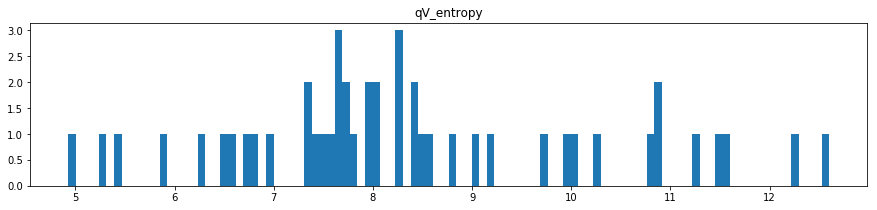

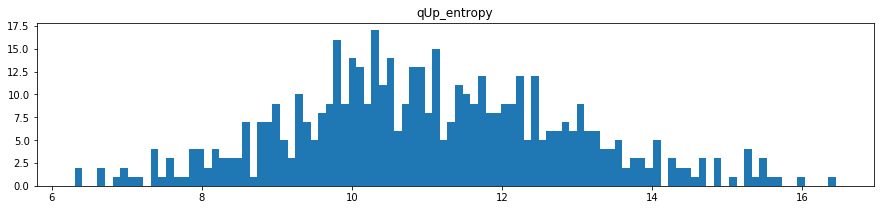

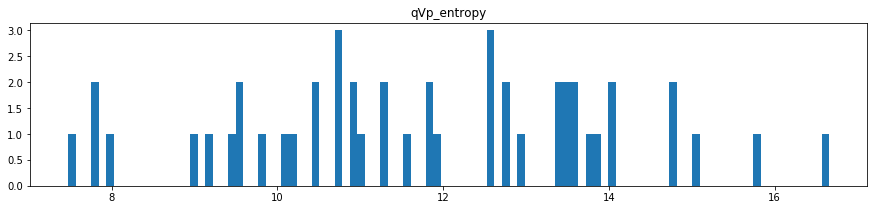

CPU times: user 51.3 s, sys: 19.1 s, total: 1min 10s
Wall time: 30.7 s
Iteration 3


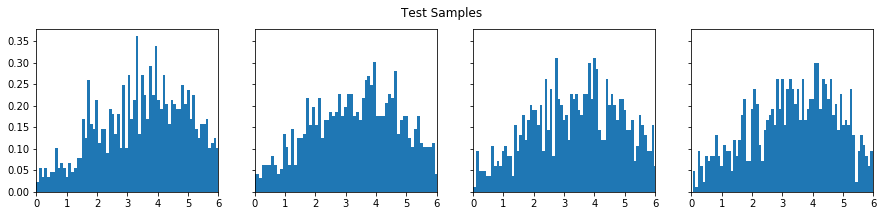

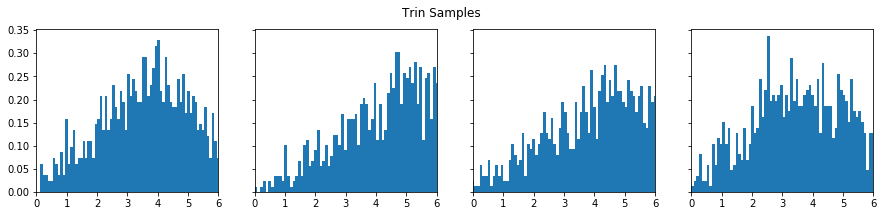

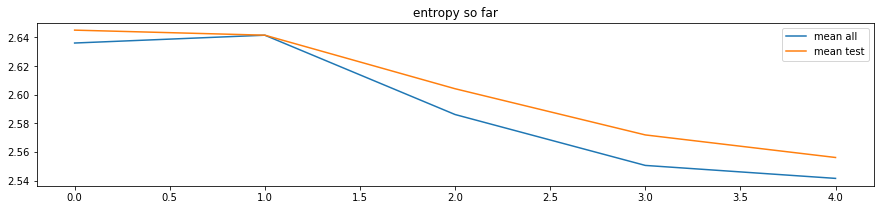

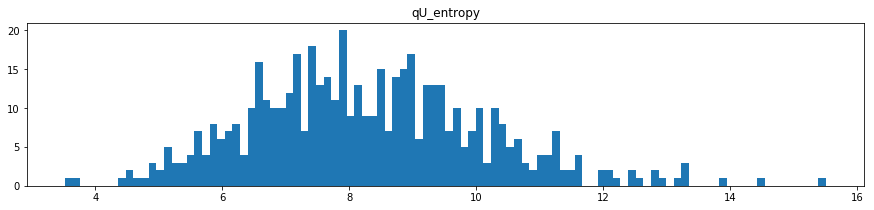

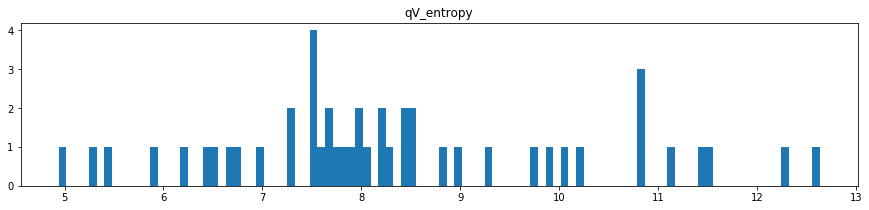

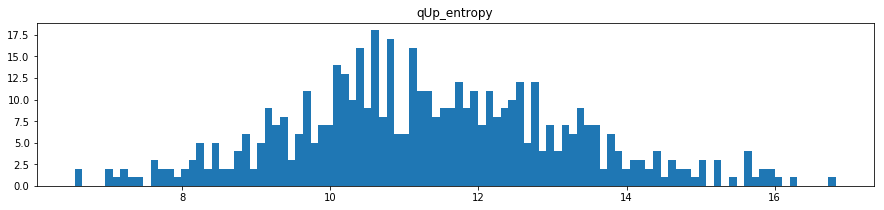

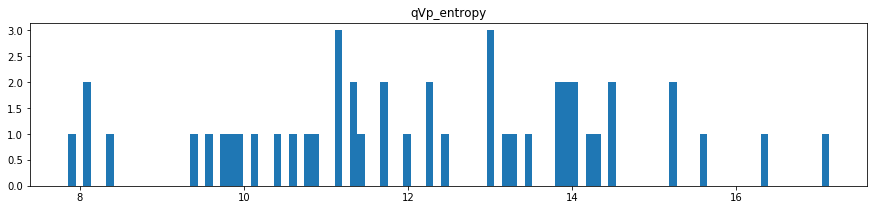

In [20]:
debug(-1, user)
losses = []

for i in range(4):
    %time _losses = model.train(train_mask, n_iter=500)
    losses = losses + _losses
    debug(i, user)

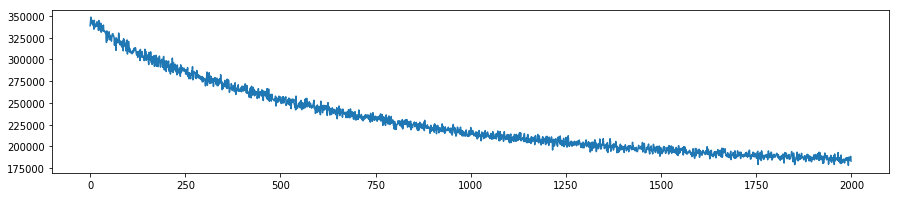

In [21]:
plt.plot(losses)

CPU times: user 51.7 s, sys: 19.4 s, total: 1min 11s
Wall time: 30.7 s
Iteration 0


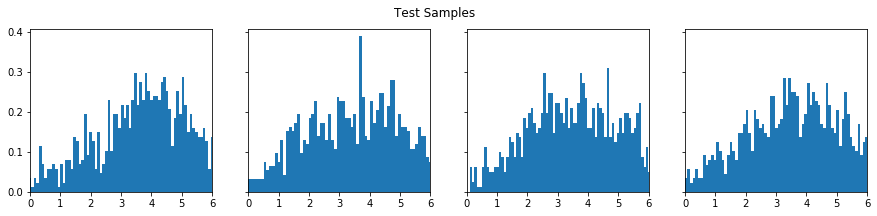

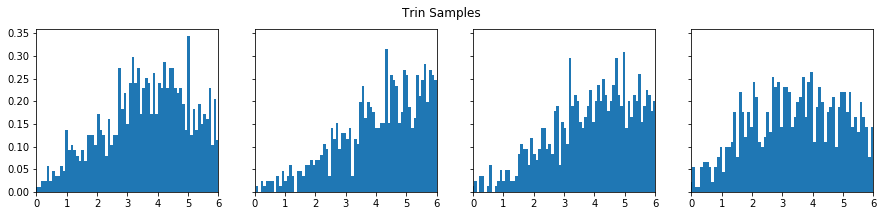

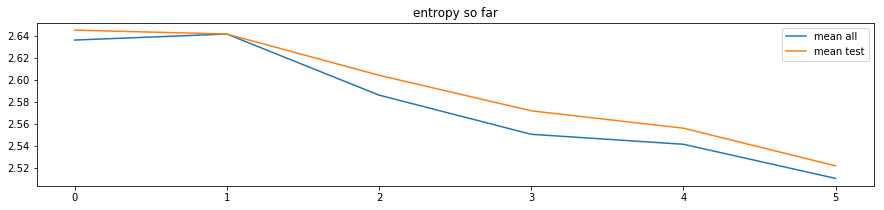

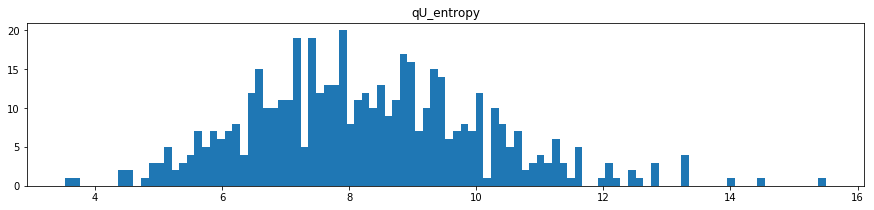

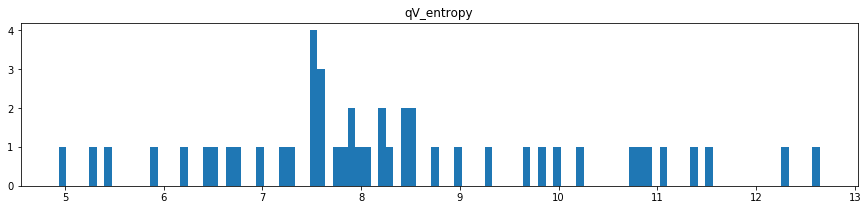

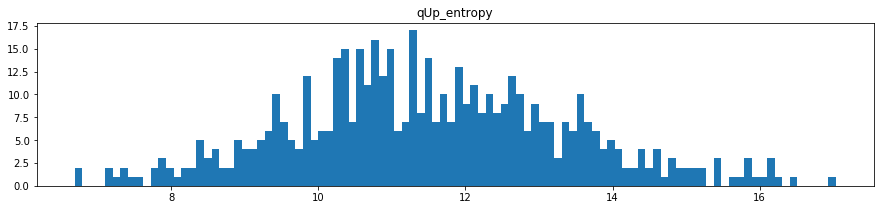

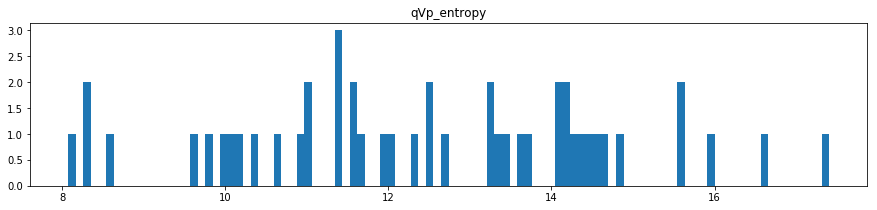

CPU times: user 51.2 s, sys: 19.8 s, total: 1min 10s
Wall time: 29.9 s
Iteration 1


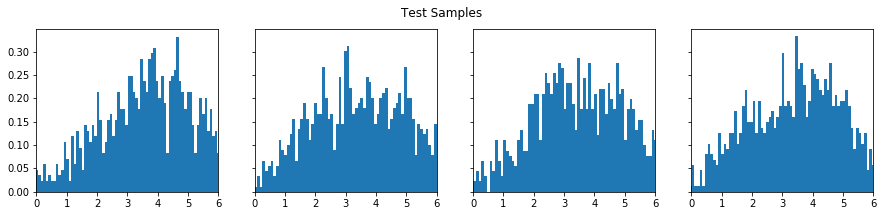

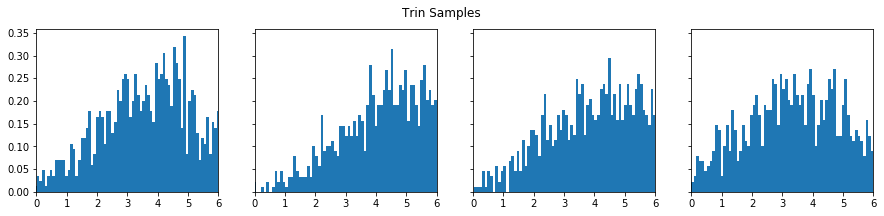

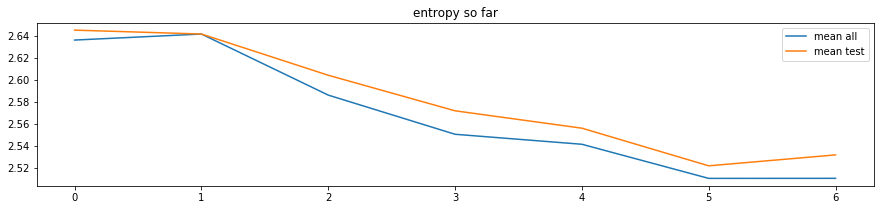

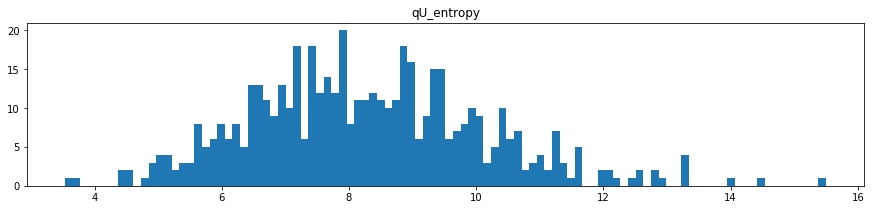

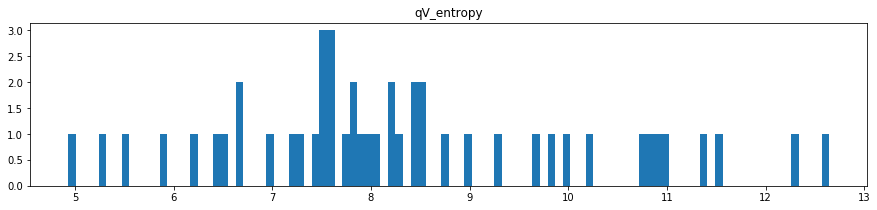

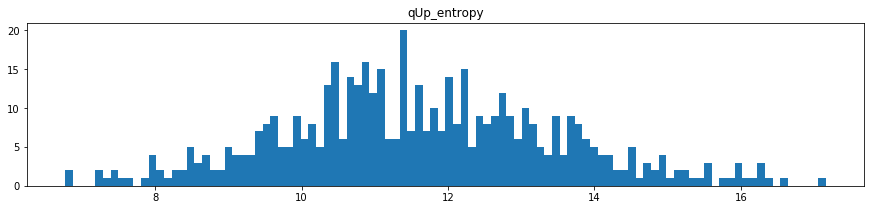

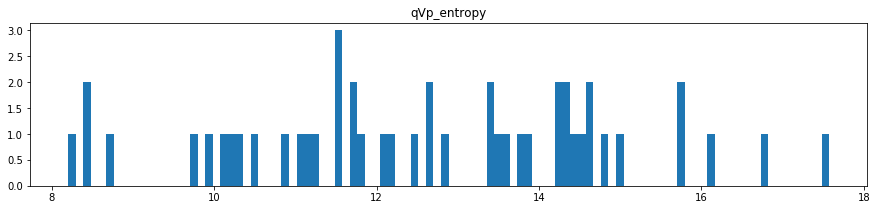

CPU times: user 51.3 s, sys: 19.7 s, total: 1min 11s
Wall time: 30.2 s
Iteration 2


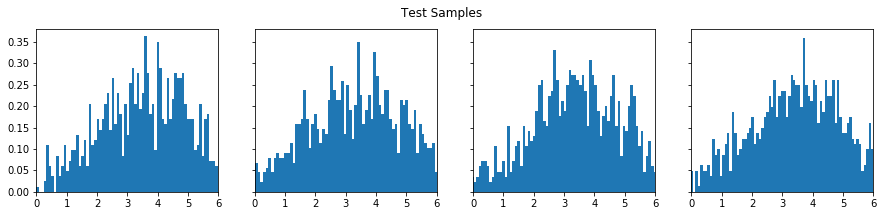

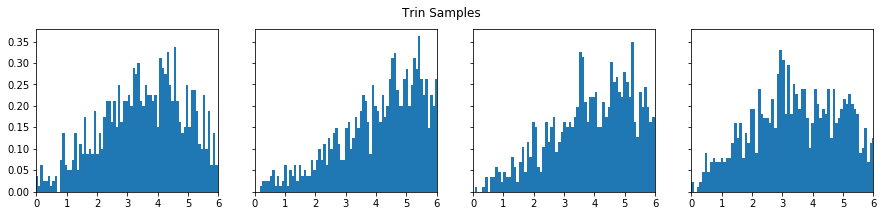

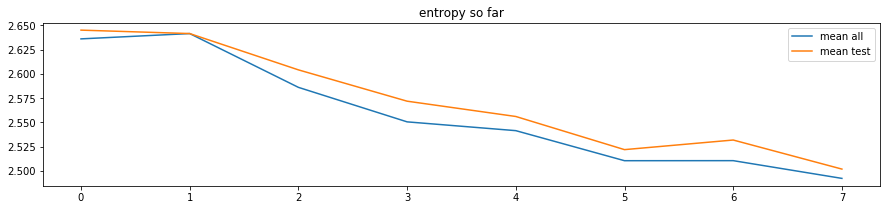

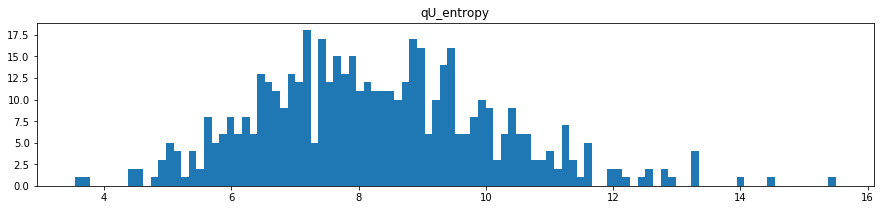

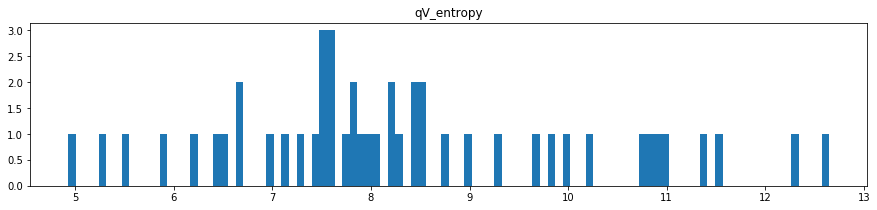

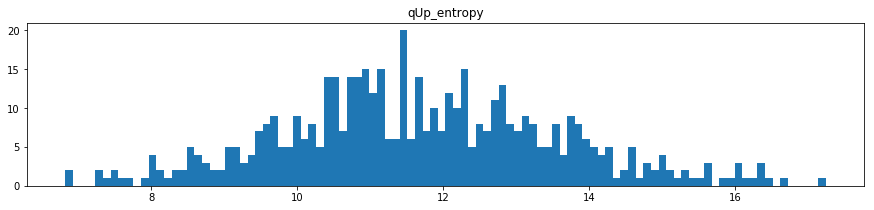

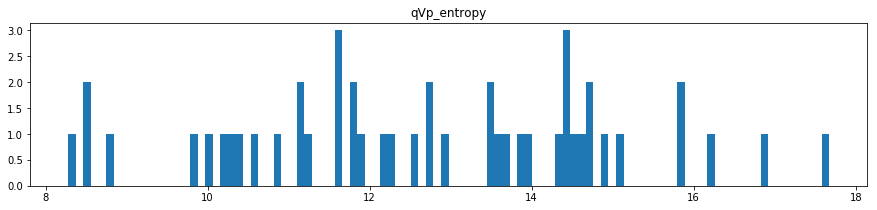

CPU times: user 51.7 s, sys: 17.3 s, total: 1min 9s
Wall time: 34.2 s
Iteration 3


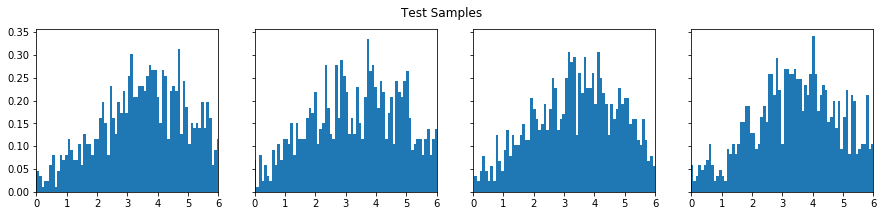

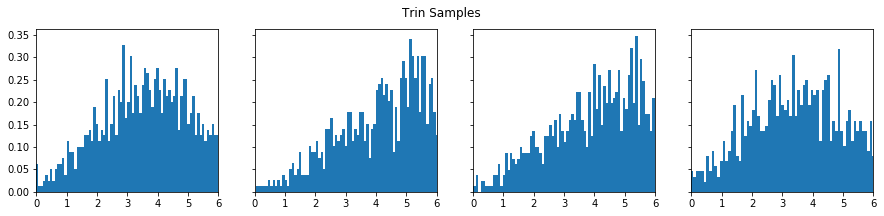

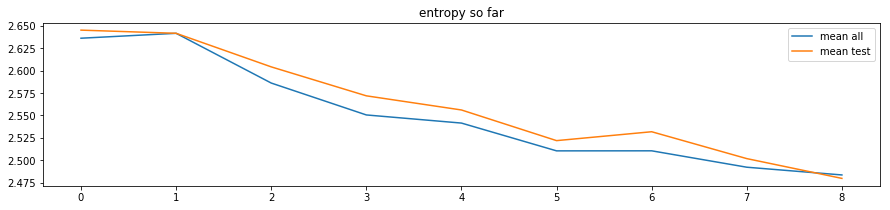

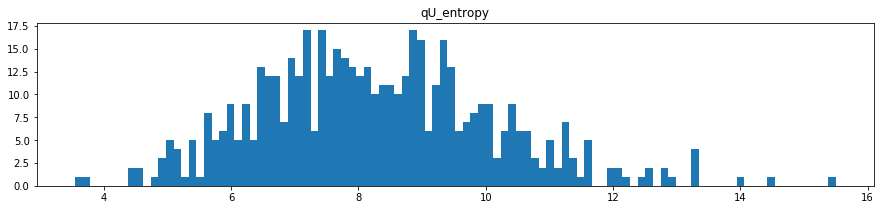

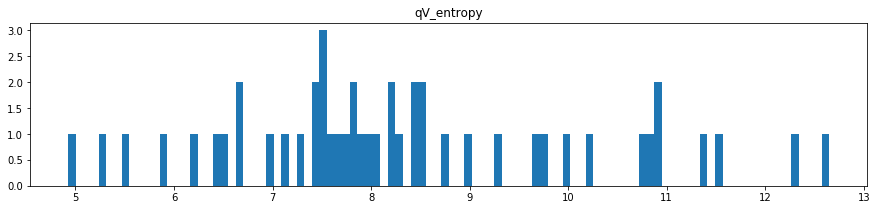

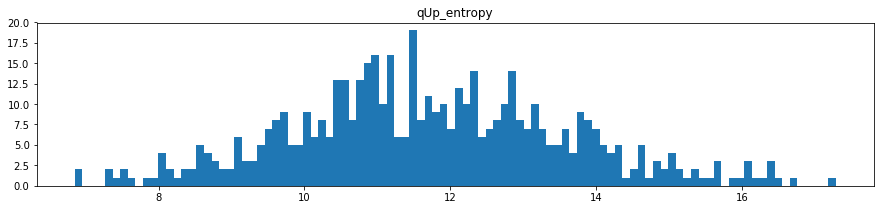

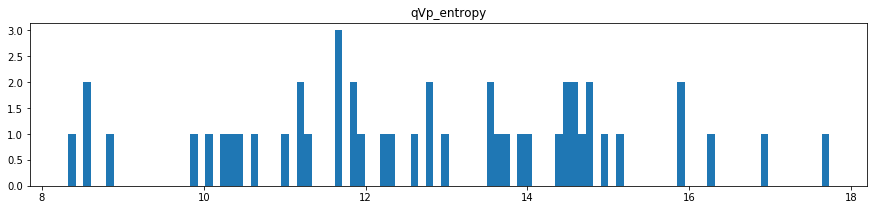

In [22]:
for i in range(4):
    %time _losses = model.train(train_mask, n_iter=500)
    losses = losses + _losses
    debug(i, user)

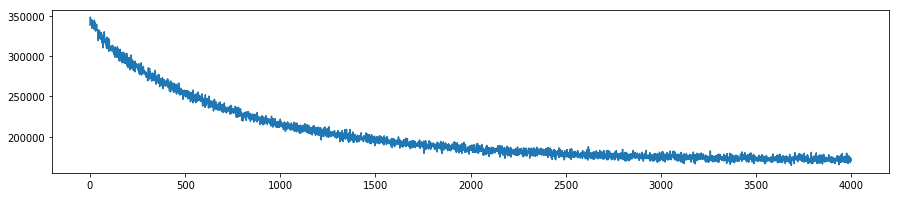

In [23]:
plt.plot(losses)

In [25]:
losses[-1]

170210.69

CPU times: user 51 s, sys: 18.5 s, total: 1min 9s
Wall time: 31.2 s
Iteration 0


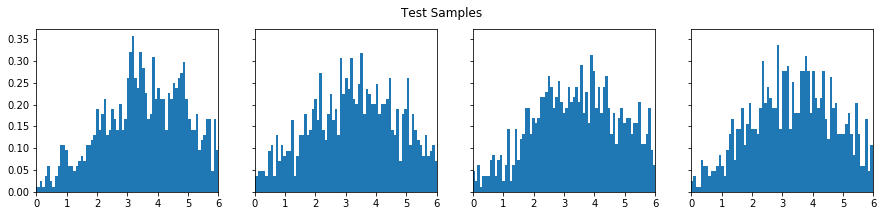

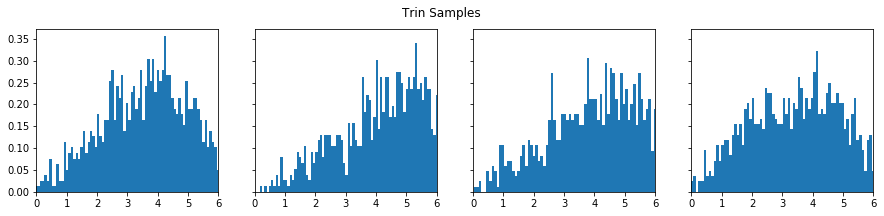

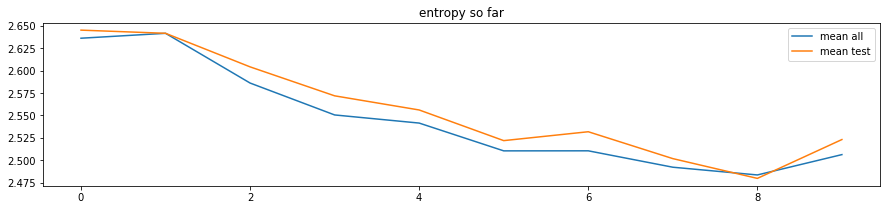

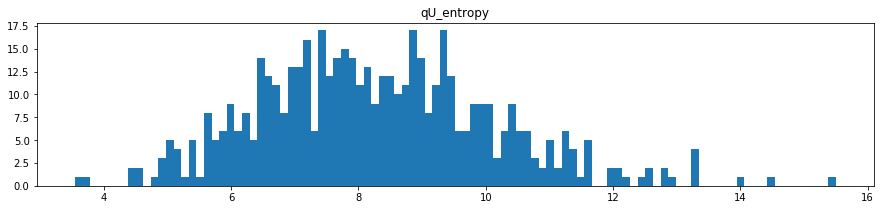

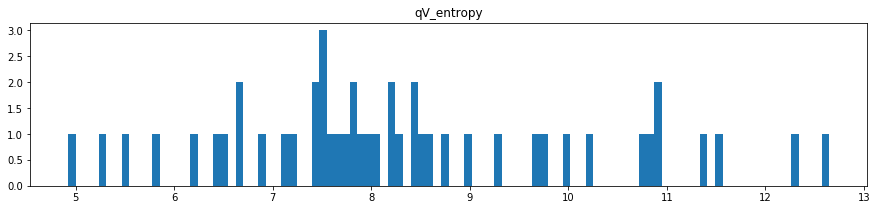

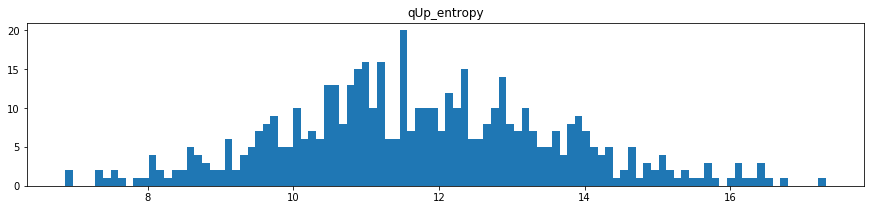

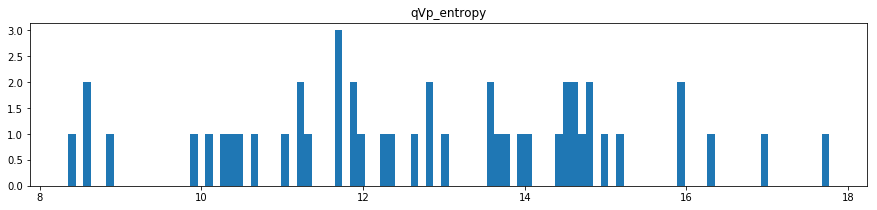

CPU times: user 51.6 s, sys: 19 s, total: 1min 10s
Wall time: 31.4 s
Iteration 1


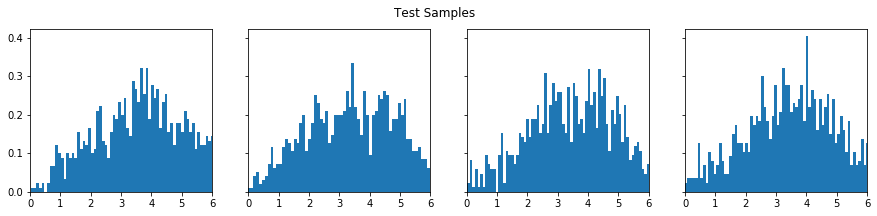

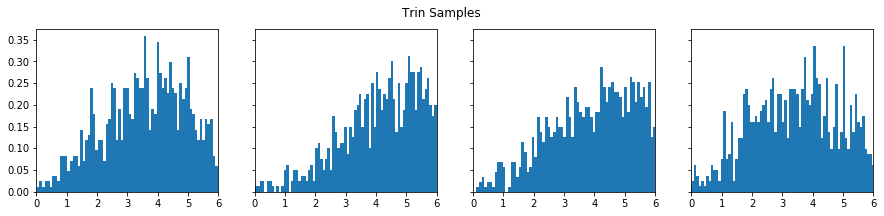

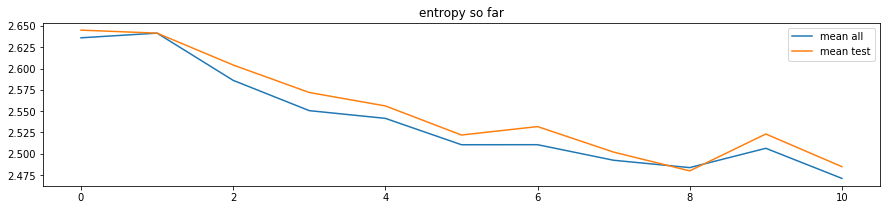

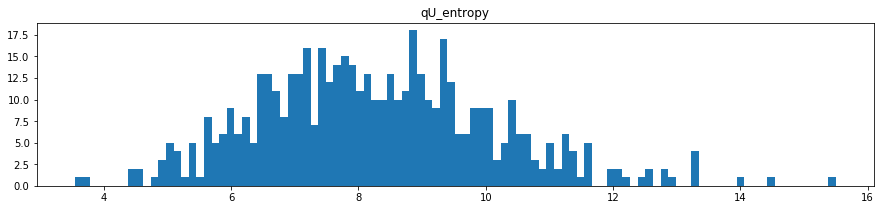

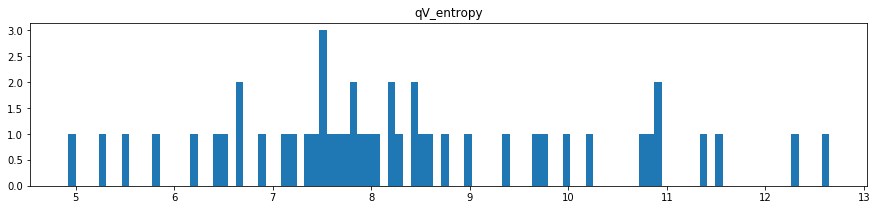

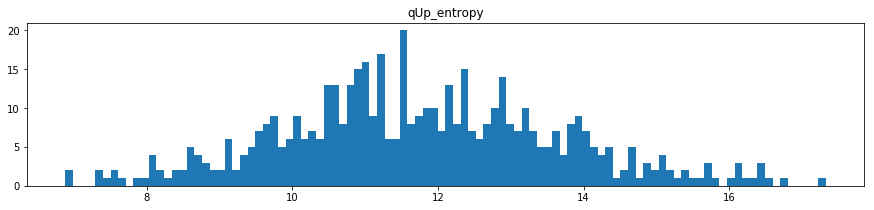

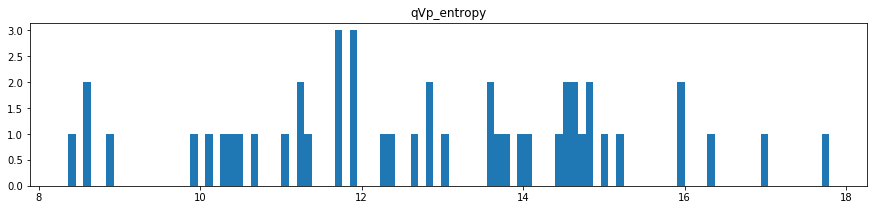

CPU times: user 52.6 s, sys: 18.2 s, total: 1min 10s
Wall time: 32.2 s
Iteration 2


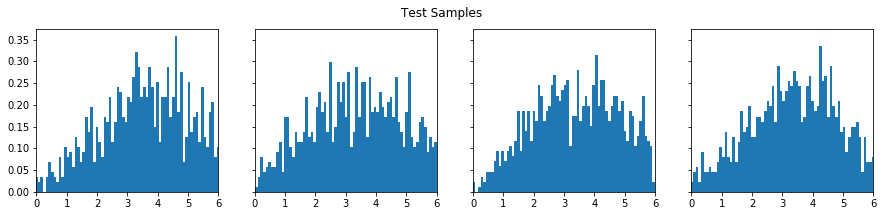

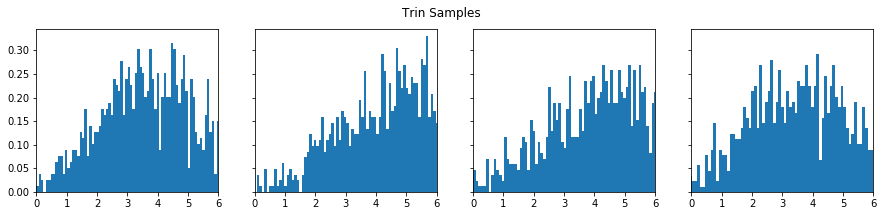

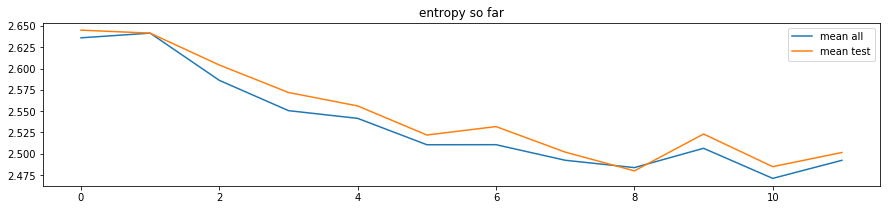

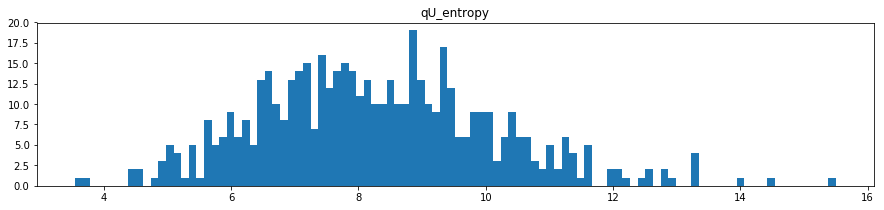

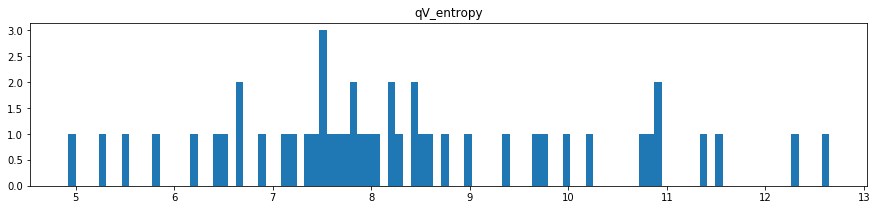

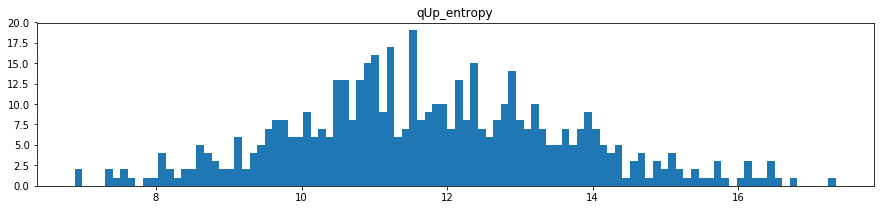

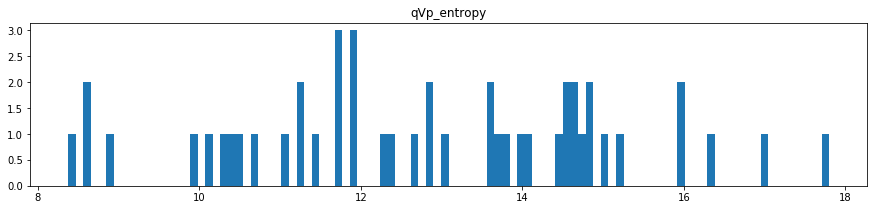

CPU times: user 52.1 s, sys: 18 s, total: 1min 10s
Wall time: 32.2 s
Iteration 3


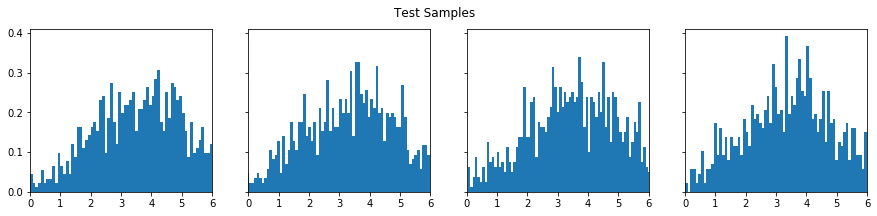

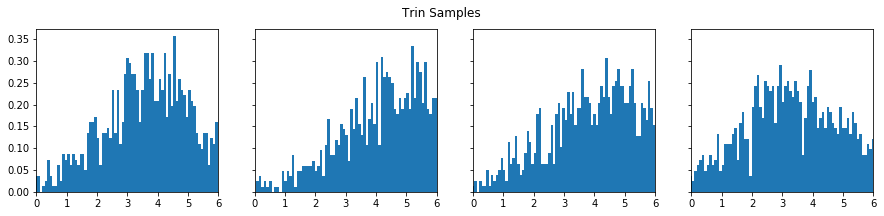

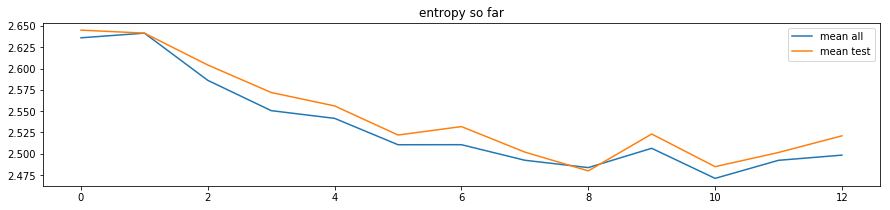

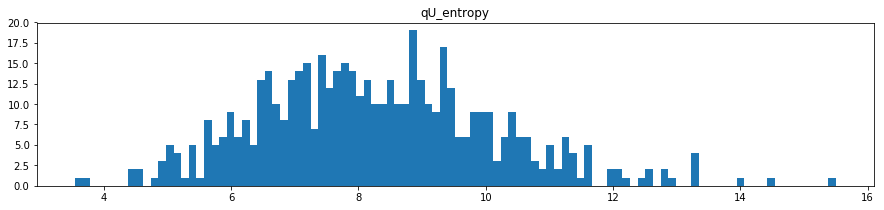

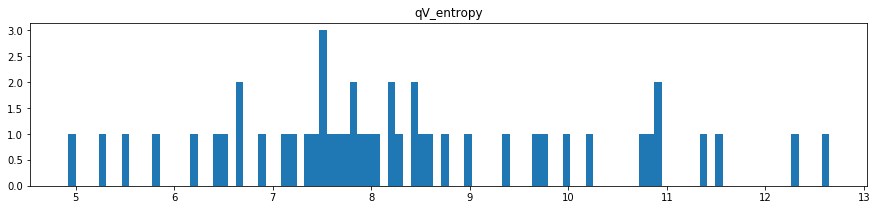

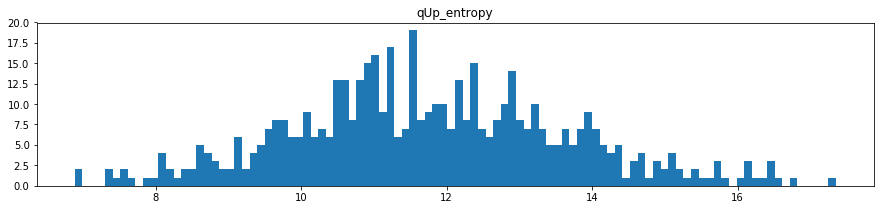

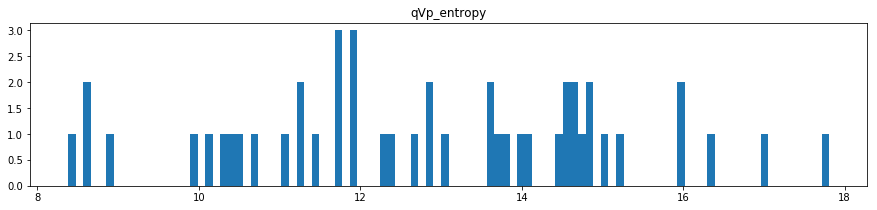

In [26]:
for i in range(4):
    %time _losses = model.train(train_mask, n_iter=500)
    losses = losses + _losses
    debug(i, user)

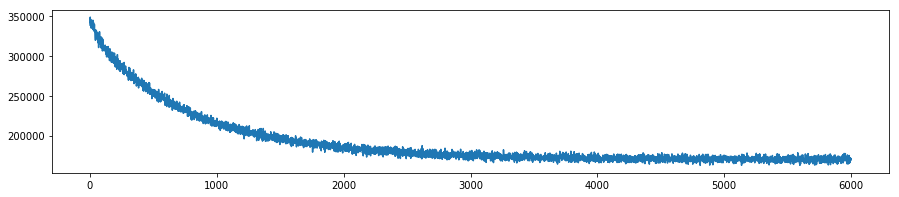

In [27]:
plt.plot(losses)

User 94


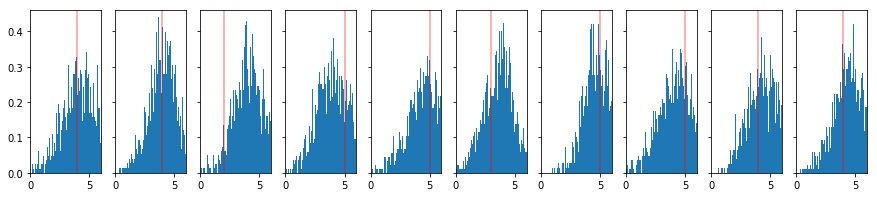

Rhats : [ 4.  4.  4.  4.  5.  4.  5.  4.  4.  4.]
Actual: [ 4.  4.  2.  5.  5.  3.  5.  5.  4.  4.]
User 169


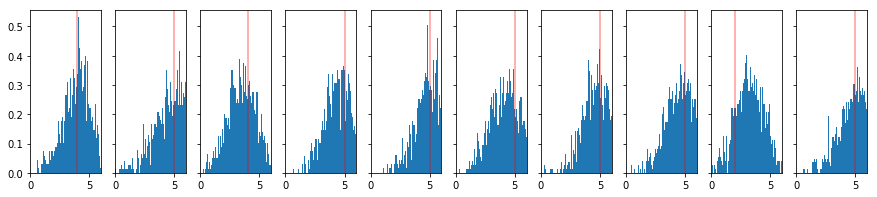

Rhats : [ 4.  5.  3.  5.  5.  4.  5.  5.  3.  5.]
Actual: [ 4.  5.  4.  5.  5.  5.  5.  5.  2.  5.]
User 234


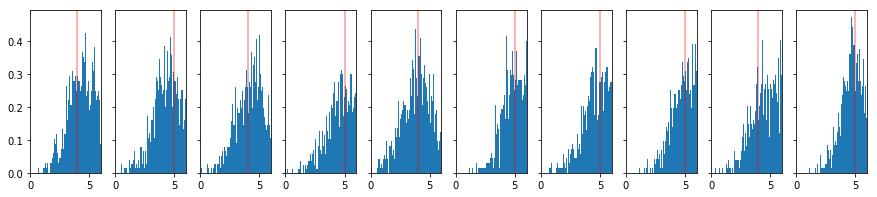

Rhats : [ 5.  5.  4.  5.  4.  5.  5.  5.  5.  5.]
Actual: [ 4.  5.  4.  5.  4.  5.  5.  5.  4.  5.]
User 9


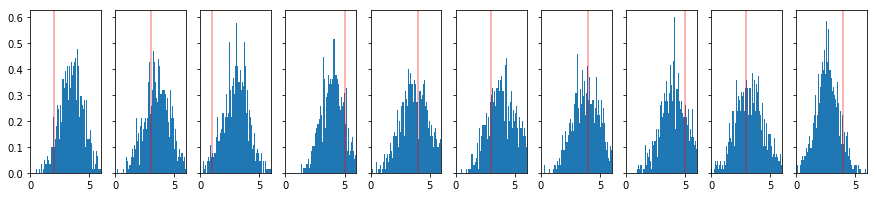

Rhats : [ 4.  4.  3.  4.  4.  4.  4.  4.  3.  3.]
Actual: [ 2.  3.  1.  5.  4.  3.  4.  5.  3.  4.]
User 117


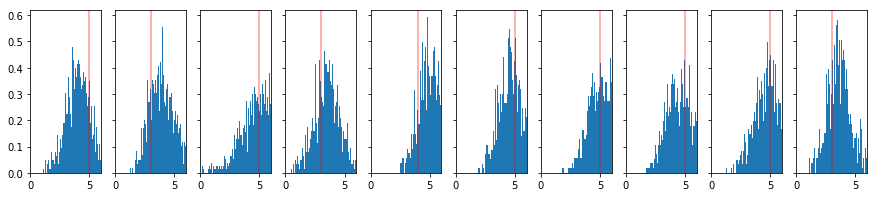

Rhats : [ 4.  4.  5.  4.  5.  5.  5.  5.  5.  4.]
Actual: [ 5.  3.  5.  3.  4.  5.  5.  5.  5.  3.]
User 150


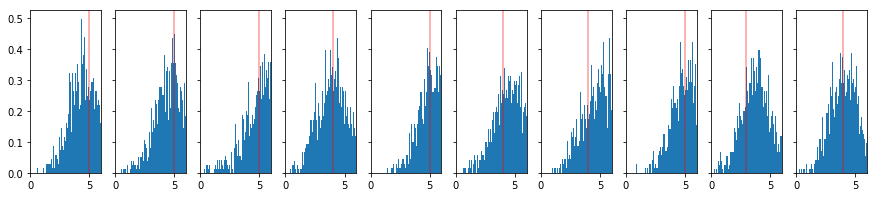

Rhats : [ 5.  5.  5.  4.  5.  5.  5.  5.  4.  4.]
Actual: [ 5.  5.  5.  4.  5.  4.  4.  5.  3.  4.]
User 209


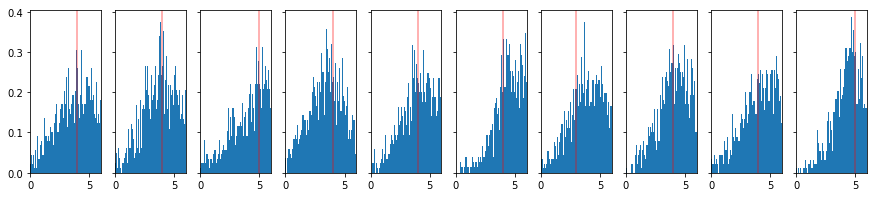

Rhats : [ 4.  4.  5.  3.  4.  5.  4.  4.  4.  5.]
Actual: [ 4.  4.  5.  4.  4.  4.  3.  4.  4.  5.]
User 248


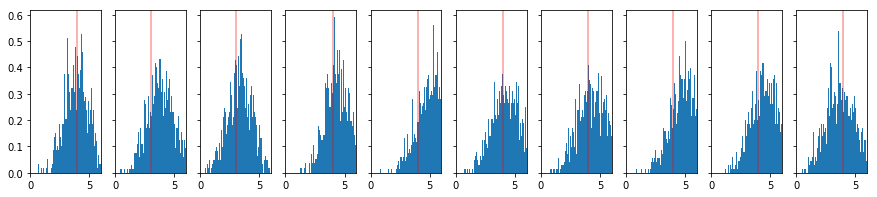

Rhats : [ 4.  4.  3.  4.  5.  4.  4.  5.  5.  4.]
Actual: [ 4.  3.  3.  4.  4.  4.  4.  4.  4.  4.]
User 326


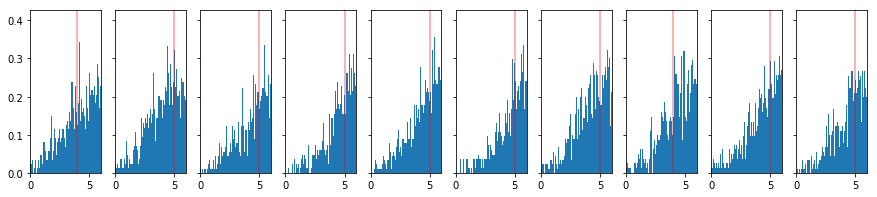

Rhats : [ 5.  4.  5.  5.  5.  5.  5.  5.  5.  5.]
Actual: [ 4.  5.  5.  5.  5.  5.  5.  4.  5.  5.]
User 184


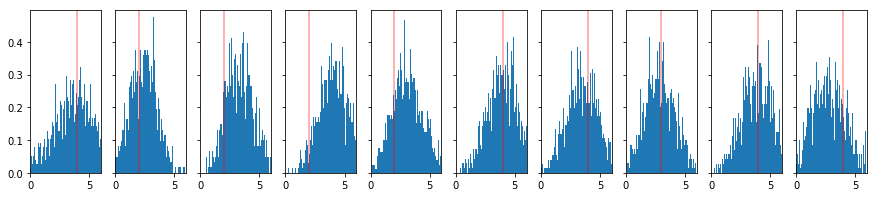

Rhats : [ 4.  2.  3.  4.  3.  4.  4.  3.  4.  3.]
Actual: [ 4.  2.  2.  2.  2.  4.  4.  3.  4.  4.]
MSE per user [0.45430322714120813, 0.60947883513441481, 0.49988136703012093, 1.2277314756507431, 0.55028279557884752, 0.21699860617768191, 0.31404777182430088, 0.28356202341203318, 0.97430989412760216, 0.74087282837826884]


In [30]:
# For now, just some mse of random users.
ids = [x[1] for x in dense_users]
#ids = [x[1] for x in spars_users]
mses = []
for user_index in ids[:10]:
    print('User', user_index)
    #idx = np.where(R[user_index] > 0)
    #idx = test_masks[user_index]
    idx = train_mask[user_index, :]
    
    samples = np.squeeze(model.sample_for_user(user_index, 1000)[:,idx])
    rhats = np.mean(samples, axis=0)
    r = R[user_index][idx]
    plot_R(samples[:,:10], r[:10])
    print("Rhats :", np.round(rhats[:10]))
    print("Actual:", r[:10])
    mses.append(np.mean(np.square(rhats - r)))
print("MSE per user", mses)

## EXP END

## Reveal Items Should Change User's Latent Distribution & Corresponding Rhat Distribution

In [79]:
#%time losses = model.train(train_mask, n_iter=100)
#_ = plt.plot(losses)

In [12]:
checkpoing_fname = 'test_checkpoing_fixednn_2000.ckpt'
# model.save(checkpoing_fname)

We checkpoint this initially trained model, then:

```
N = some small number (eg. 100)

For each user u:
    reset mask
    for each unseen item i:
        update mask
        reload model
        show item i to user u, finetune model on mask with N steps
        measure how much the posterior changed (eg. via entropy)
```

In [39]:
def get_user_latent_entropy(model, user):
    import tensorflow as tf

    sess = model.sess
    graph_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    U_var  = graph_vars[1]
    Up_var = graph_vars[5]

    U_entropy = joint_entropy(sess.run(tf.nn.softplus(U_var)))
    Up_entropy = joint_entropy(sess.run(tf.nn.softplus(Up_var)))
    
    return U_entropy[user], Up_entropy[user]


---------------------- USER 94 ----------------------

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 51.1 s, sys: 17.9 s, total: 1min 9s
Wall time: 31.5 s


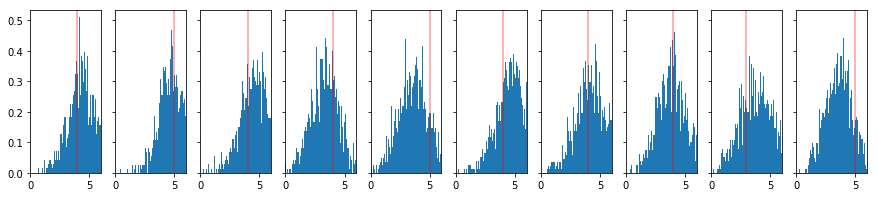

Rhats : [ 5.  5.  5.  3.  4.  5.  4.  4.  4.  4.]
Actual: [ 4.  5.  4.  4.  5.  4.  4.  4.  3.  5.]
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.640872, 12.924842)
1 11
2 11
3 11
4 11
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.6407466, 12.924982)
5 11
6 11
7 11
8 11
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.6407294, 12.925147)
9 11
10 11

---------------------- USER 169 ----------------------

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 51.3 s, sys: 18.5 s, total: 1min 9s
Wall time: 31.3 s


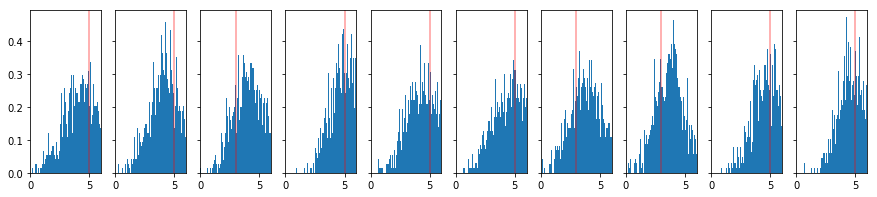

Rhats : [ 4.  4.  4.  5.  4.  5.  4.  4.  5.  5.]
Actual: [ 5.  5.  3.  5.  5.  5.  3.  3.  5.  5.]
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.8319559, 12.394479)
1 18
2 18
3 18
4 18
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.8317432, 12.394743)
5 18
6 18
7 18
8 18
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(7.8316231, 12.394855)
9 18
10 18

---------------------- USER 234 ----------------------

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 50.7 s, sys: 18.6 s, total: 1min 9s
Wall time: 29.8 s


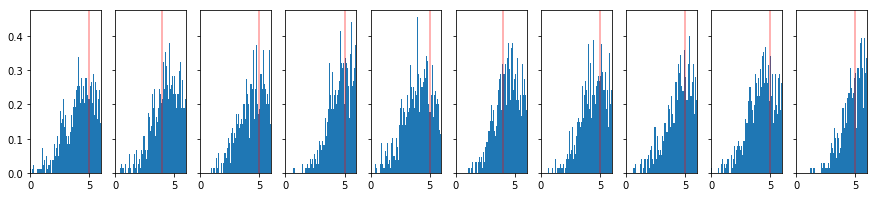

Rhats : [ 5.  5.  5.  5.  4.  5.  5.  5.  5.  5.]
Actual: [ 5.  4.  5.  5.  5.  4.  5.  5.  5.  5.]
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.8919954, 11.596275)
1 11
2 11
3 11
4 11
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.8918843, 11.596518)
5 11
6 11
7 11
8 11
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.8918319, 11.596589)
9 11
10 11

---------------------- USER 9 ----------------------

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 51.7 s, sys: 18.1 s, total: 1min 9s
Wall time: 30.6 s


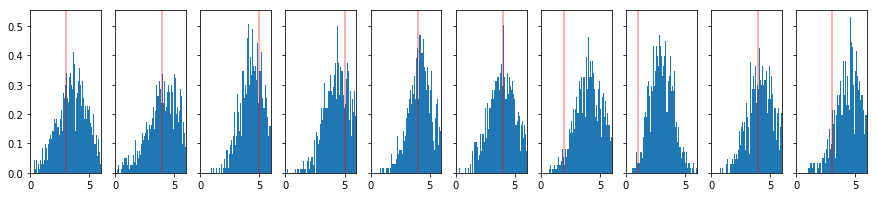

Rhats : [ 4.  4.  4.  4.  4.  4.  4.  3.  4.  5.]
Actual: [ 3.  4.  5.  5.  4.  4.  2.  1.  4.  3.]
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(8.427804, 13.077745)
1 10
2 10
3 10
4 10
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(8.4277725, 13.07799)
5 10
6 10
7 10
8 10
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(8.4277964, 13.078239)
9 10
10 10

---------------------- USER 117 ----------------------

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 52 s, sys: 18.2 s, total: 1min 10s
Wall time: 32.2 s


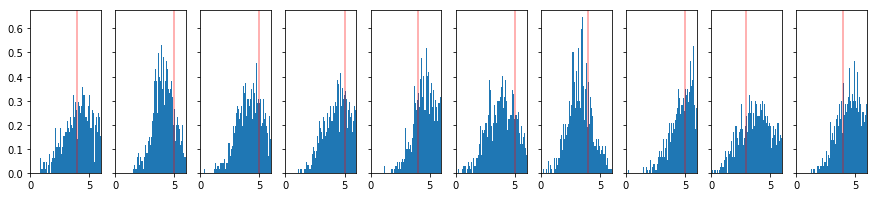

Rhats : [ 4.  4.  4.  5.  5.  4.  3.  5.  4.  5.]
Actual: [ 4.  5.  5.  5.  4.  5.  4.  5.  3.  4.]
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.7209644, 12.332067)
1 18
2 18
3 18
4 18
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.7207298, 12.332328)
5 18
6 18
7 18
8 18
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
(6.720571, 12.332301)
9 18
10 18


In [40]:
N_STEPS_FINETUNE = 500

dense_user_entropy_data = {}

N_USERS = 5

for _, user in dense_users[:N_USERS]:
    print()
    print("---------------------- USER {} ----------------------".format(user))
    print()
    
    entropy_data = []
    
    model.load(checkpoing_fname)
    %time model.train(train_mask, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
    entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
    item_ids = np.where(test_masks[user])[0][:10]
    mask_ = np.copy(train_mask)
    
    # Idea: Just train on this user for a bit, so we can see its entropy get better.
    mask_[:user,:] = False
    mask_[user:,:] = False
    
    cnt = 0
    
    def print_debug_info():
        samples = np.squeeze(model.sample_for_user(user, 1000)[:,item_ids])
        rhats = np.mean(samples, axis=0)
        r = R[user][item_ids]
        plot_R(samples, r)
        print("Rhats :", np.round(rhats))
        print("Actual:", r)
    
    print_debug_info()
    
    for item in item_ids:
        cnt += 1
        mask_[user,item] = 1 # Pretend we showed this item to the user.
        
        if cnt == 1 or cnt == 5 or cnt == 9:
            model.load(checkpoing_fname)
            model.train(mask_, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
            entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))

            print(get_user_latent_entropy(model, user))
            print_debug_info()
        
        print(cnt, np.sum(test_masks[user]))
    
    dense_user_entropy_data[user] = entropy_data

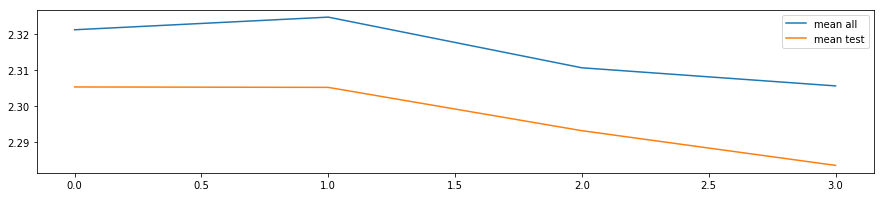

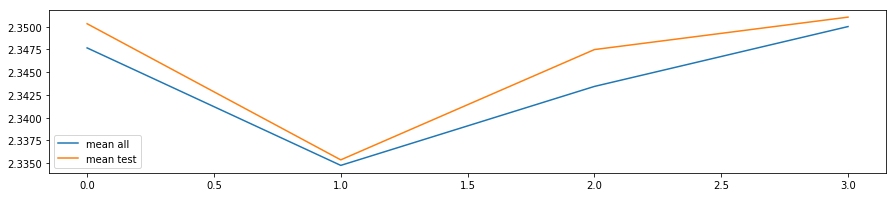

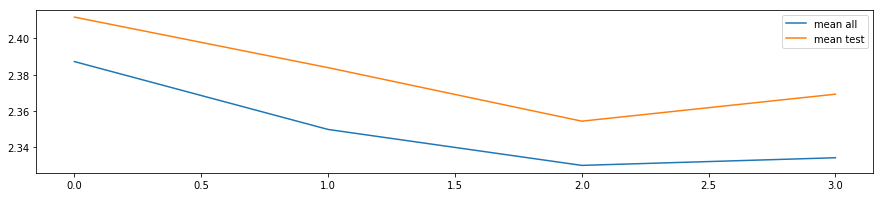

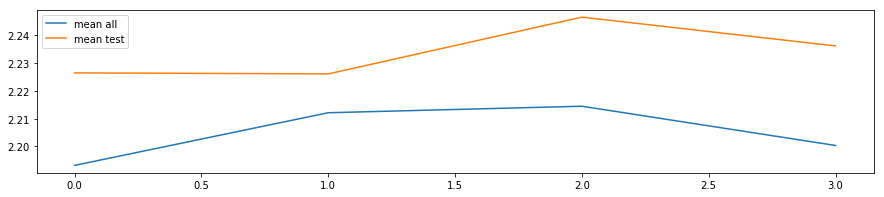

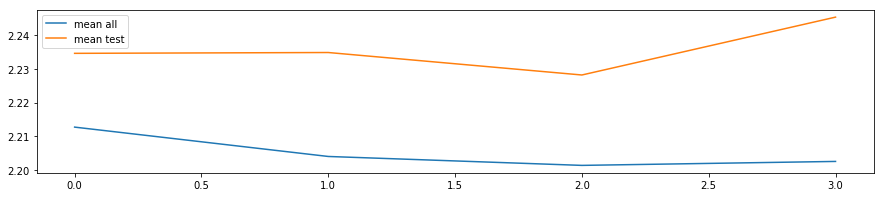

In [41]:
for u in dense_users[:N_USERS]:
    user_id = u[1]
    plt.plot([x[0] for x in dense_user_entropy_data[user_id]], label='mean all')
    plt.plot([x[1] for x in dense_user_entropy_data[user_id]], label='mean test')
    plt.legend()
    _ = plt.show()

---

In [86]:
N_STEPS_FINETUNE = 200 # 20 doesn't seem to make a difference in entropy.

spars_user_entropy_data = {}

for _, user in spars_users[:5]:
    entropy_data = []
    
    model.load(checkpoing_fname)
    %time model.train(train_mask, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
    entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
    cnt = 0
    
    mask_ = np.copy(train_mask)
    for item in np.where(test_masks[user])[0]:
        model.load(checkpoing_fname)
        mask_[user,item] = 1 # Pretend we showed this item to the user.
        model.train(mask_, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
        entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
        cnt += 1
        print(cnt, np.sum(test_masks[user]))
        if cnt >= 20: # DEBUG
            break
    
    spars_user_entropy_data[user] = entropy_data

INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 20.8 s, sys: 7.24 s, total: 28 s
Wall time: 13.2 s
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
1 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
2 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
3 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
4 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
CPU times: user 20.4 s, sys: 7.86 s, total: 28.3 s
Wall time: 12 s
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
1 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
2 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
3 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckpt
4 4
INFO:tensorflow:Restoring parameters from test_checkpoing_fixednn_2000.ckp

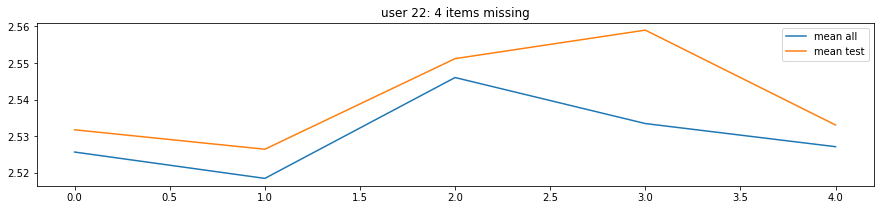

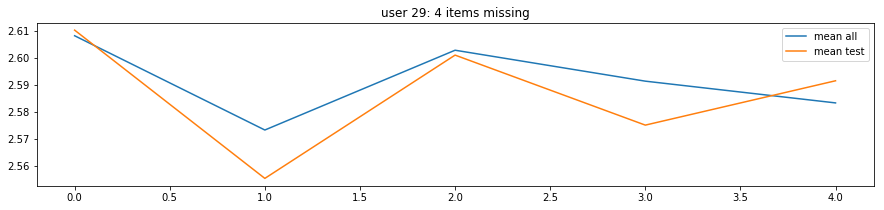

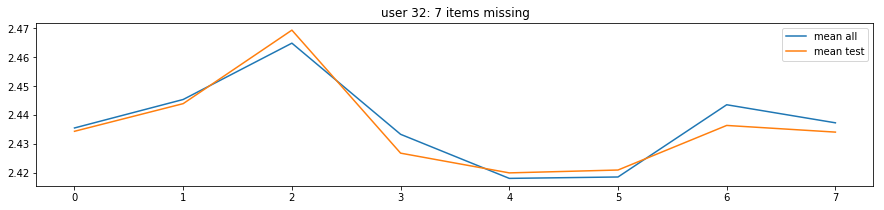

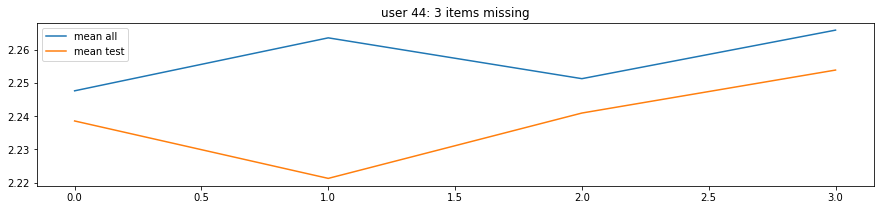

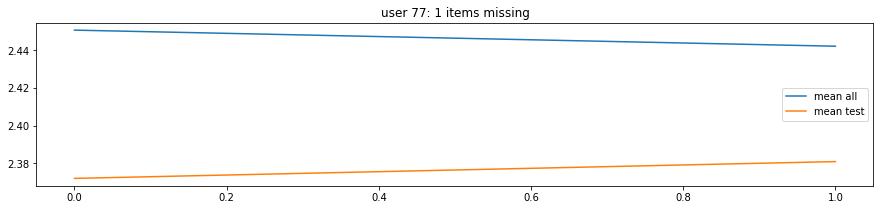

KeyError: 82

In [87]:
for _, user in spars_users[:10]:
    plt.plot([x[0] for x in spars_user_entropy_data[user]], label='mean all')
    plt.plot([x[1] for x in spars_user_entropy_data[user]], label='mean test')
    n_missing = np.sum(test_masks[user])
    plt.title("user {}: {} items missing".format(user, n_missing))
    plt.legend()
    _ = plt.show()

---